In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter

In [4]:
# Install required packages
!pip install langdetect
!pip install nltk
!pip install sbnltk
!pip install textblob
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=c852799925c53839279ab4d32225ec7c24e3509e2663b59e28903b1697683f1e
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5

In [5]:
# Import text processing libraries
import pandas as pd
import re
import string
from langdetect import detect
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sbnltk.Stemmer import stemmerOP
from sbnltk.Preprocessor import preprocessor
from sbnltk.Tokenizer import wordTokenizer, sentenceTokenizer
from textblob import TextBlob
from imblearn.over_sampling import SMOTE  # Add SMOTE for handling imbalanced classes

Downloading...
From: https://drive.google.com/uc?id=142XvJg9xdpgzuYD31Y4pm-ZVdMaWmtuq
To: /usr/local/lib/python3.11/dist-packages/sbnltk/dataset/download_link.txt
100%|██████████| 1.66k/1.66k [00:00<00:00, 4.39MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UIR2arP_6Fm0MqJVbcG2Q9iLCnjQriDB
To: /usr/local/lib/python3.11/dist-packages/sbnltk/dataset/bangla_word_list.txt
100%|██████████| 15.4M/15.4M [00:00<00:00, 79.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1e4x5FQrdGyEfBBzQ_DOJ9wBxZZ1F7bx7
To: /usr/local/lib/python3.11/dist-packages/sbnltk/dataset/stopword_list.txt
100%|██████████| 4.77k/4.77k [00:00<00:00, 8.95MB/s]


In [6]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

In [7]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [8]:
# Load data
df = pd.read_excel('/content/drive/MyDrive/TechTalentAssignment/Data & Topics.xlsx')
df.drop_duplicates(inplace=True)
print(f"Dataset shape after removing duplicates: {df.shape}")

Dataset shape after removing duplicates: (551, 3)


In [9]:
# Define text processing functions
# Emoji removal pattern
emoji_pattern = re.compile(
    "["
    u"\U0001F600-\U0001F64F"  # Emoticons
    u"\U0001F300-\U0001F5FF"  # Symbols & Pictographs
    u"\U0001F680-\U0001F6FF"  # Transport & Map
    u"\U0001F1E0-\U0001F1FF"  # Flags
    u"\U00002700-\U000027BF"  # Dingbats
    u"\U0001F900-\U0001F9FF"  # Supplemental symbols
    u"\U0001FA70-\U0001FAFF"  # Extended-A (🫵)
    u"\U00002600-\U000026FF"  # Misc symbols
    u"\U0001F000-\U0001F02F"  # Mahjong
    u"\U0000203C"             # Double exclamation
    u"\uFE0F"                 # Variation Selector-16
    "]+",
    flags=re.UNICODE
)

# Custom punctuation (Bangla, Urdu, Arabic)
custom_punct = '।॥''""…،؛؟'
all_punct = string.punctuation + custom_punct

# Load stopwords
en_stop = set(stopwords.words('english'))

# Initialize processors
en_lem = WordNetLemmatizer()
bn_preprocessor = preprocessor()
bn_word_tokenizer = wordTokenizer()
bn_stemmer = stemmerOP()

# Detect Bengali characters
def is_bengali(word):
    return bool(re.search(r'[\u0980-\u09FF]', word))

# Clean and preprocess text
def preprocess_text(text):
    text = str(text)

    # Remove URLs, hashtags, mentions
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"@\w+", "", text)

    # Remove emojis
    text = emoji_pattern.sub('', text)

    # Remove punctuations
    text = re.sub(f"[{re.escape(all_punct)}]", "", text)

    # Normalize space
    text = re.sub(r'\s+', ' ', text).strip()

    try:
        lang = detect(text)
    except:
        lang = 'en'

    # For Bengali text, use SBNLTK tokenizer
    if (lang == 'bn'):
        try:
            text = bn_preprocessor.word_normalize(text)
            # Tokenize into words
            tokens = bn_word_tokenizer.basic_tokenizer(text)

            # Apply stemming to each token
            tokens = [bn_stemmer.stemWord(t) for t in tokens]
            # Apply dust remove to each token
            tokens = [bn_preprocessor.dust_removal(t) for t in tokens]
        except:
            # Fallback to NLTK if SBNLTK fails
            tokens = word_tokenize(text)
            tokens = [t.lower() for t in tokens if t.isalpha()]
    else:
        # For English, use NLTK with TextBlob correction
        try:
            textBlb = TextBlob(text)
            textBlb = textBlb.correct()
            text = textBlb.string
        except:
            # If TextBlob correction fails
            pass

        # Tokenize into words
        tokens = word_tokenize(text)
        tokens = [t.lower() for t in tokens if t.isalpha()]

    clean_tokens = []
    for token in tokens:
        if is_bengali(token):
            # Bengali tokens are already preprocessed and stemmed
            clean_tokens.append(token)
        else:
            if token not in en_stop:
                lemma = en_lem.lemmatize(token)
                clean_tokens.append(lemma)

    return ' '.join(clean_tokens)  # Return as space-separated string for TF-IDF

Downloading...
From: https://drive.google.com/uc?id=1ohRYMGAeq4RZTa3W-7DXEsaUCaVNIxgO
To: /usr/local/lib/python3.11/dist-packages/sbnltk/dataset/rootword_list.txt
100%|██████████| 2.00M/2.00M [00:00<00:00, 39.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oBEK2DUs6Jt155AmMyc9565dHJJFZd_N
To: /usr/local/lib/python3.11/dist-packages/sbnltk/dataset/ner_static.txt
100%|██████████| 20.2M/20.2M [00:00<00:00, 46.9MB/s]


In [10]:
# Apply preprocessing to data
print("Applying text preprocessing...")
df['clean_context'] = df['Context'].apply(preprocess_text)

Applying text preprocessing...


In [11]:
# Remove empty documents after cleaning
df = df[df['clean_context'].str.strip() != '']
print(f"Dataset shape after removing empty documents: {df.shape}")

Dataset shape after removing empty documents: (544, 4)


In [12]:
# Check class distribution
X = df['clean_context']
y = df['Training Topic']

print("\nChecking class distribution...")
class_counts = y.value_counts()
print(class_counts)


Checking class distribution...
Training Topic
Mob Justice                   124
Law and Order                  66
Politics                       59
Islamic Fundamentalism         45
International affairs          34
Religion                       33
Corruption                     30
National Defence               27
Diplomacy                      24
Governance & Policy Reform     20
Women Rights                   19
Sports                         15
Terrorism                      12
Election                       11
Culture & Lifestyle            10
Trade & Commodity Price         6
Education                       4
Environment                     2
Natural Disaster                2
Religious Conflict              1
Name: count, dtype: int64


In [13]:
# Filter out classes with only one sample
print("\nRemoving classes with only one sample...")
valid_classes = class_counts[class_counts >= 15].index
filtered_df = df[df['Training Topic'].isin(valid_classes)]
print(f"Original dataset size: {len(df)}")
print(f"Filtered dataset size: {len(filtered_df)}")


Removing classes with only one sample...
Original dataset size: 544
Filtered dataset size: 496


In [14]:
# Get the new X and y from filtered dataset
X = filtered_df['clean_context']
y = filtered_df['Training Topic']

In [15]:
# 2. Implement stratified cross-validation rather than a single train/test split
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. Create a proper preprocessing and modeling pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=3000,  # Reduced from 5000 to prevent overfitting
        min_df=3,           # Increased minimum document frequency
        max_df=0.7,         # Reduced maximum document frequency
        ngram_range=(1, 2)  # Keep unigrams and bigrams
    )),
    # 4. Use SMOTETomek which combines over and undersampling
    ('sampling', SMOTETomek(random_state=42)),
    # 5. Try a simpler model with regularization
    ('classifier', LogisticRegression(
        C=1.0,              # Regularization strength
        class_weight='balanced',  # Built-in class weight balancing
        max_iter=1000,
        solver='liblinear',  # More stable for small datasets
        random_state=42
    ))
])

In [ ]:
# def get_sampling_strategy():
#     strategy = {}
#     for class_name, count in class_counts.items():
#         if count > 30:  # Undersample large classes
#             strategy[class_name] = 30
#         elif count < 10 and count >= 2:  # Oversample small classes
#             strategy[class_name] = 10
#         # Medium classes keep their original count
#     return strategy

In [16]:
# 6. Properly implement cross-validation with parameter tuning
param_grid = {
    'tfidf__max_features': [2000, 3000],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [0.7, 0.8],
    'classifier__C': [0.1, 1.0, 10.0],
}

# 7. Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='f1_weighted',  # Use F1 weighted for imbalanced classes
    verbose=1,
    n_jobs=-1  # Use all available cores
)


Finding optimal parameters with GridSearchCV...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters:
{'classifier__C': 10.0, 'tfidf__max_df': 0.7, 'tfidf__max_features': 2000, 'tfidf__min_df': 3}

--- Test set evaluation ---
Accuracy: 0.4430

Classification Report:
                            precision    recall  f1-score   support

                Corruption       0.20      0.22      0.21         9
                 Diplomacy       0.25      0.29      0.27         7
Governance & Policy Reform       0.40      0.33      0.36         6
     International affairs       0.29      0.20      0.24        10
    Islamic Fundamentalism       0.47      0.64      0.55        14
             Law and Order       0.43      0.30      0.35        20
               Mob Justice       0.58      0.76      0.66        37
          National Defence       0.50      0.25      0.33         8
                  Politics       0.36      0.22      0.28        18
                  Religio

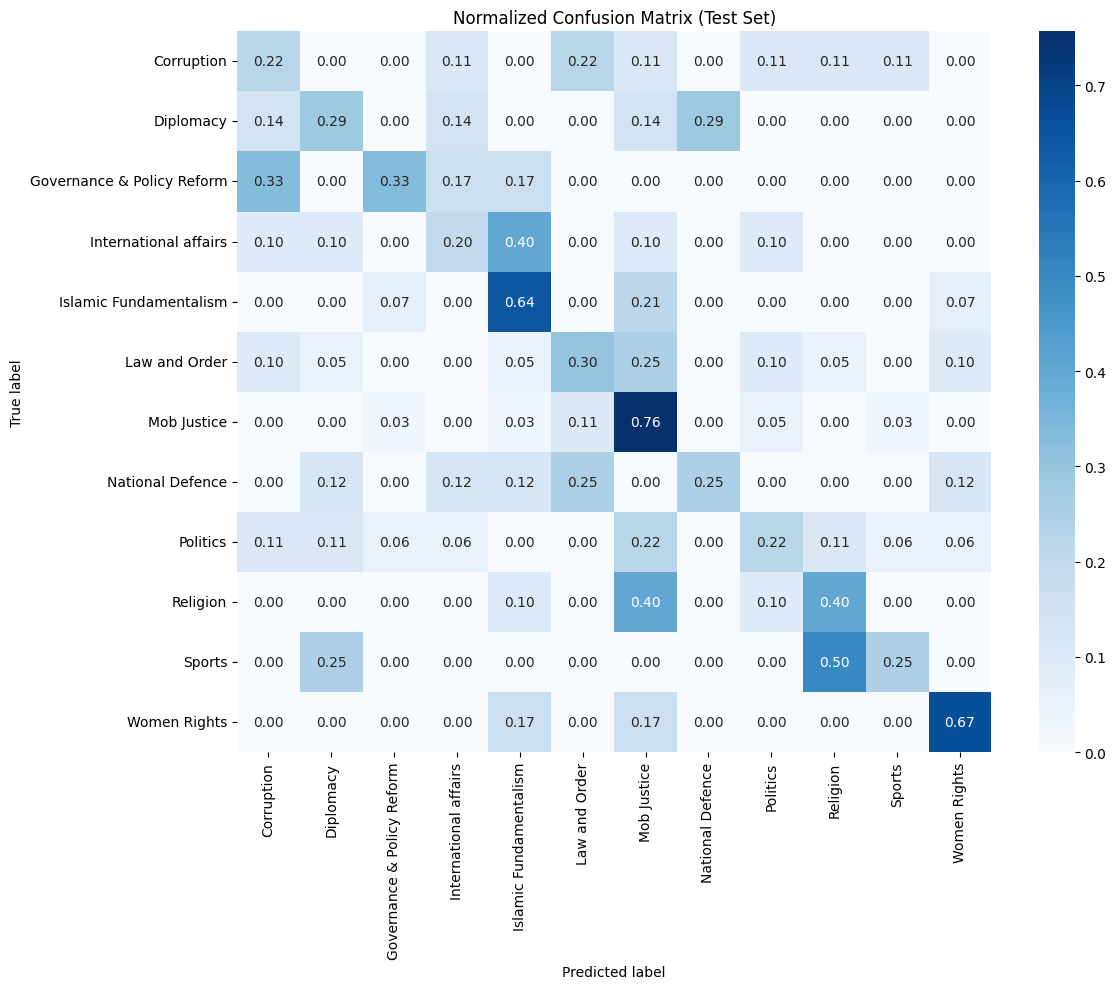

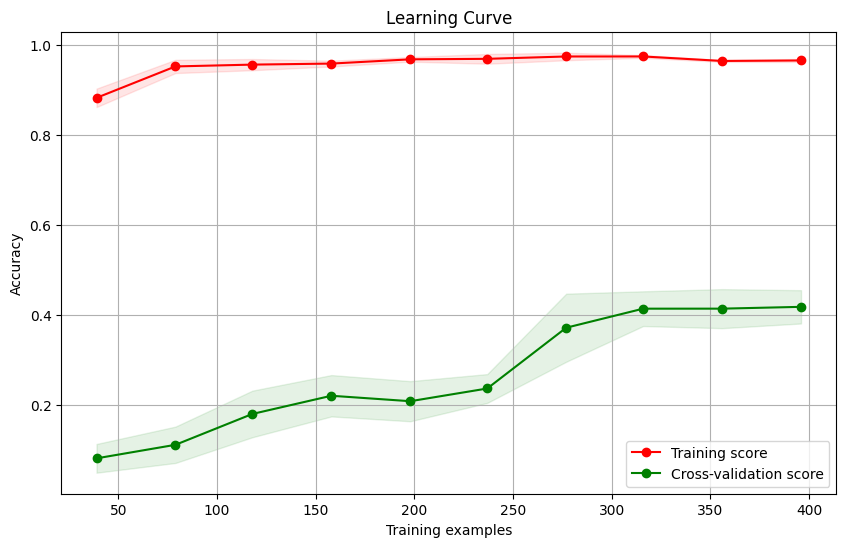

Improved model saved successfully!


In [17]:
# 8. Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 9. Fit the model
print("\nFinding optimal parameters with GridSearchCV...")
grid_search.fit(X_train, y_train)

# Print best parameters
print("\nBest parameters:")
print(grid_search.best_params_)

# Use best model for final evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 10. Evaluate final model
print("\n--- Test set evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 11. Visualize confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title('Normalized Confusion Matrix (Test Set)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('improved_confusion_matrix.png')
plt.show()

# 12. Learning curves to visualize overfitting
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy')

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.grid()
    plt.savefig('learning_curve.png')
    plt.show()

# Get the final classifier from the pipeline
final_classifier = Pipeline([
    ('tfidf', best_model.named_steps['tfidf']),
    ('classifier', best_model.named_steps['classifier'])
])

# Plot learning curve
plot_learning_curve(final_classifier, X, y)

# Save the improved model
joblib.dump(best_model, 'improved_text_classification_model.pkl')
print("Improved model saved successfully!")

In [ ]:
# Now perform the train-test split
# print("\nPerforming train-test split...")
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


Performing train-test split...


In [ ]:
# # TF-IDF Vectorization
# print("\nApplying TF-IDF vectorization...")
# tfidf_vectorizer = TfidfVectorizer(
#     max_features=5000,  # Limit features to prevent overfitting
#     min_df=2,           # Ignore terms that appear in less than 2 documents
#     max_df=0.8,         # Ignore terms that appear in more than 80% of documents
#     ngram_range=(1, 2)  # Use both unigrams and bigrams
# )
# X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# X_test_tfidf = tfidf_vectorizer.transform(X_test)


Applying TF-IDF vectorization...


In [ ]:
# # Apply SMOTE for handling class imbalance
# print("\nApplying SMOTE to handle class imbalance...")
# smote = SMOTE(random_state=42, k_neighbors=min(15, len(y_train[y_train == y_train.value_counts().index[-1]]) - 1) ) # k_neighbors should be less than the number of samples in the minority class
# # Adjust k_neighbors dynamically based on minority class size
# # smote = SMOTE(random_state=42, k_neighbors=min(5, X_train_tfidf.shape[0] - 1))
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)


Applying balanced sampling strategy...


ValueError: The {'Trade & Commodity Price', 'Environment', 'Natural Disaster', 'Education'} target class is/are not present in the data.

In [ ]:
# # Apply combined undersampling and oversampling
# print("\nApplying balanced sampling strategy...")
# undersampler = RandomUnderSampler(
#     sampling_strategy=get_sampling_strategy(),
#     random_state=42
# )
# oversampler = SMOTE(
#     sampling_strategy='auto',  # Will oversample all minority classes to match the majority
#     random_state=42,
#     k_neighbors=5  # Lower k_neighbors for small classes
# )

# # Apply undersampling then oversampling in a pipeline
# sampling_pipeline = Pipeline([
#     ('undersample', undersampler),
#     ('oversample', oversampler)
# ])

# X_train_resampled, y_train_resampled = sampling_pipeline.fit_resample(X_train_tfidf, y_train)



Training logistic regression model on resampled data...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

In [ ]:
# # Make predictions
# print("Making predictions...")
# y_train_pred = model.predict(X_train_tfidf)  # Predict on original training data
# y_test_pred = model.predict(X_test_tfidf)

Making predictions...



--- Training set evaluation (on original training data) ---
Accuracy: 0.9268

Classification Report:
                            precision    recall  f1-score   support

                Corruption       1.00      0.92      0.96        24
                 Diplomacy       0.90      0.95      0.92        19
Governance & Policy Reform       0.89      1.00      0.94        16
     International affairs       1.00      0.89      0.94        27
    Islamic Fundamentalism       0.81      0.94      0.87        36
             Law and Order       0.98      0.77      0.86        53
               Mob Justice       0.94      0.98      0.96        99
          National Defence       1.00      0.86      0.93        22
                  Politics       0.90      0.96      0.93        47
                  Religion       0.93      0.96      0.94        26
                    Sports       1.00      0.92      0.96        12
              Women Rights       0.83      1.00      0.91        15

            

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


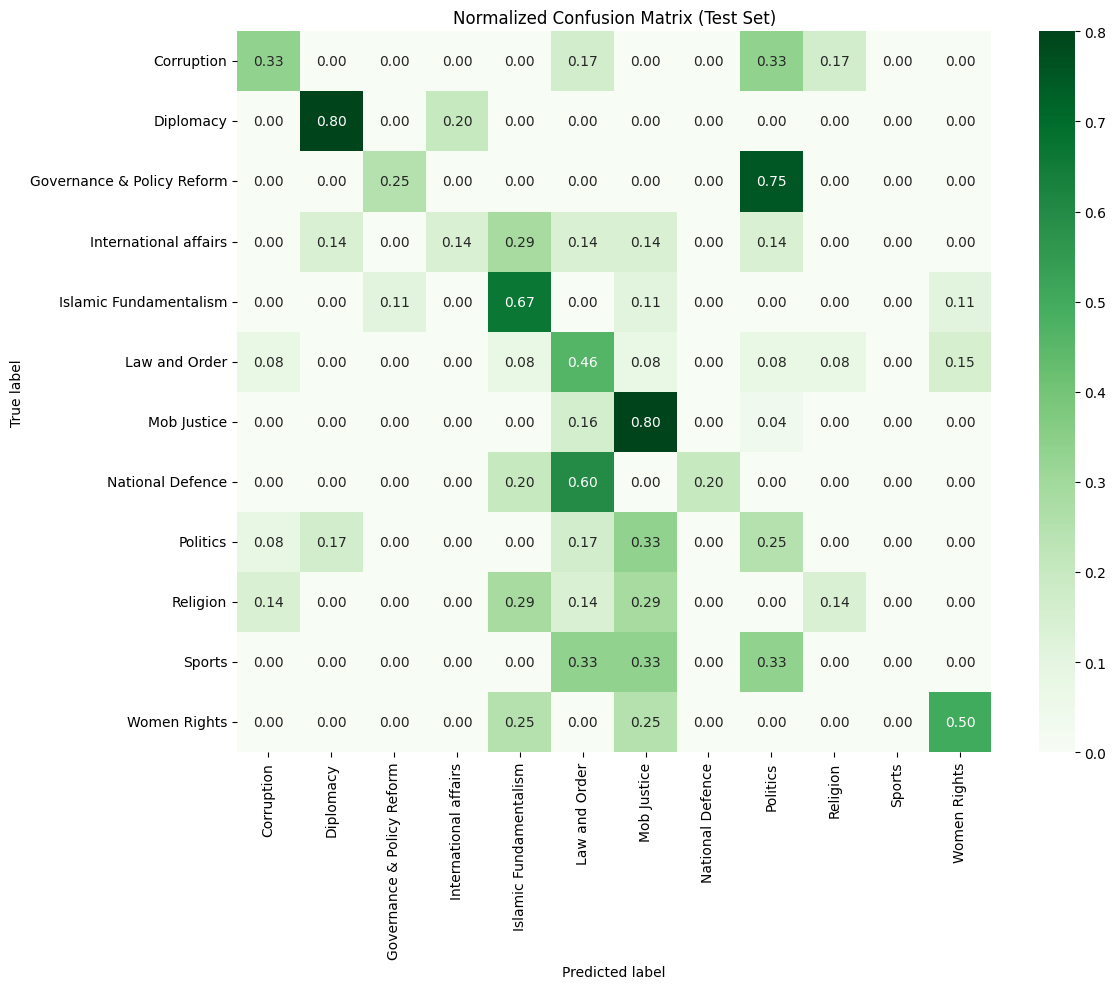

In [ ]:
# # Calculate metrics
# print("\n--- Training set evaluation (on original training data) ---")
# print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
# print("\nClassification Report:")
# print(classification_report(y_train, y_train_pred))

# print("\n--- Test set evaluation ---")
# print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
# print("\nClassification Report:")
# print(classification_report(y_test, y_test_pred))

# # Generate confusion matrix for test set
# print("\nGenerating confusion matrices...")

# # Plot normalized confusion matrix for test set
# plt.figure(figsize=(12, 10))
# cm_test = confusion_matrix(y_test, y_test_pred)
# cm_test_normalized = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# sns.heatmap(cm_test_normalized, annot=True, fmt='.2f', cmap='Greens',
#             xticklabels=model.classes_, yticklabels=model.classes_)
# plt.title('Normalized Confusion Matrix (Test Set)')
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.xticks(rotation=90)
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.savefig('confusion_matrix.png')  # Save the figure
# plt.show()

In [ ]:
# # Save the model and vectorizer
# print("\nSaving model and vectorizer...")
# joblib.dump(model, 'text_classification_model.pkl')
# joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
# print("Model and vectorizer saved successfully!")


Saving model and vectorizer...
Model and vectorizer saved successfully!



Most important features for each class:
Class 'Corruption': রত বন, সপ, ছড়, জব ছড়, পয়স, আম, উল, লগঞ, সন, অর, জব, গঠন, অভ, কফ, দক
Class 'Culture & Lifestyle': head full, international, usaid, region, meeting, together, per, bangladesh news, boy, paper, উপর, ইত, উপর কর, ইসল ধর, উফল
Class 'Diplomacy': shake, air, indian, visit, indian army, army chief, دیش, بنگلہ دیش, اور, بنگلہ, বলল, army, staff, chief, রত
Class 'Education': বয়স, হব, এট মব, আঘ কর, মল কর, হব মল, আস, মব কর, পদত, এরপর, রছ, চল, চল আস, উচ, এট
Class 'Election': হল চন, চন যম, basin, capital, minister, চন পর, crime, হল, এক, crime minister, election, রক, government, protest, চন
Class 'Environment': রন, আপন, আস, লব, ইব, ইব লব, অন যতম, যতম, রন রত, আস ইব, ষন অন, time, stop, human, global
Class 'Governance & Policy Reform': উত, interim government, দরক, টপ করব, মস, তর, government, কর মস, শব কর, interim, শব, change, bangladesh islamist, লব, করব
Class 'International affairs': army, army chief, basin, india basin, mean, bangladeshi, সল, 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1200x800 with 0 Axes>

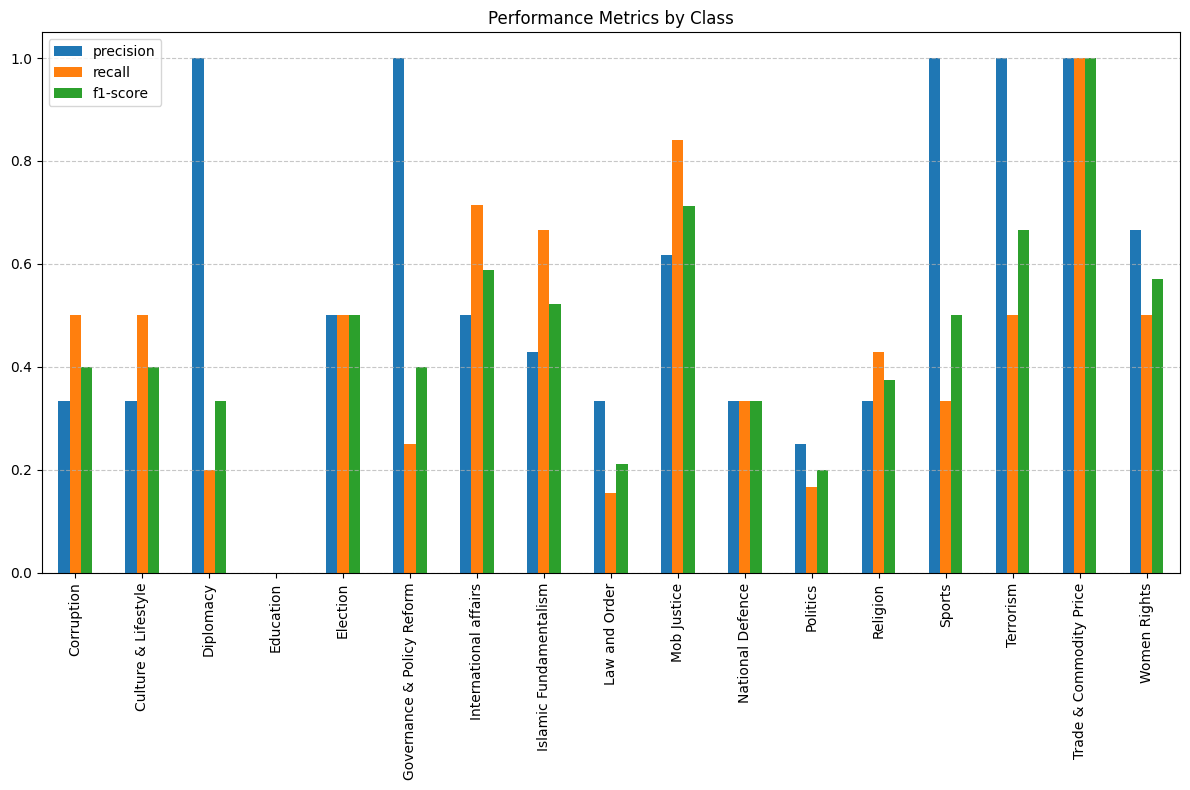


Detailed per-class metrics (sorted by F1-score):
                            precision    recall  f1-score     support
Education                    0.000000  0.000000  0.000000    1.000000
Politics                     0.250000  0.166667  0.200000   12.000000
Law and Order                0.333333  0.153846  0.210526   13.000000
Diplomacy                    1.000000  0.200000  0.333333    5.000000
National Defence             0.333333  0.333333  0.333333    6.000000
Religion                     0.333333  0.428571  0.375000    7.000000
Culture & Lifestyle          0.333333  0.500000  0.400000    2.000000
Corruption                   0.333333  0.500000  0.400000    6.000000
Governance & Policy Reform   1.000000  0.250000  0.400000    4.000000
macro avg                    0.566444  0.446277  0.453655  109.000000
weighted avg                 0.511911  0.486239  0.458325  109.000000
accuracy                     0.486239  0.486239  0.486239    0.486239
Election                     0.500000  0

<ipython-input-26-8eb3316c1e6b>:75: UserWarning: Glyph 2478 (\N{BENGALI LETTER MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-26-8eb3316c1e6b>:75: UserWarning: Matplotlib currently does not support Bengali natively.
  plt.tight_layout()
<ipython-input-26-8eb3316c1e6b>:75: UserWarning: Glyph 2476 (\N{BENGALI LETTER BA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-26-8eb3316c1e6b>:75: UserWarning: Glyph 2447 (\N{BENGALI LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-26-8eb3316c1e6b>:75: UserWarning: Glyph 2480 (\N{BENGALI LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-26-8eb3316c1e6b>:75: UserWarning: Glyph 2453 (\N{BENGALI LETTER KA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-26-8eb3316c1e6b>:75: UserWarning: Glyph 2460 (\N{BENGALI LETTER JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-26-8eb3316c1e6b>:75: UserW

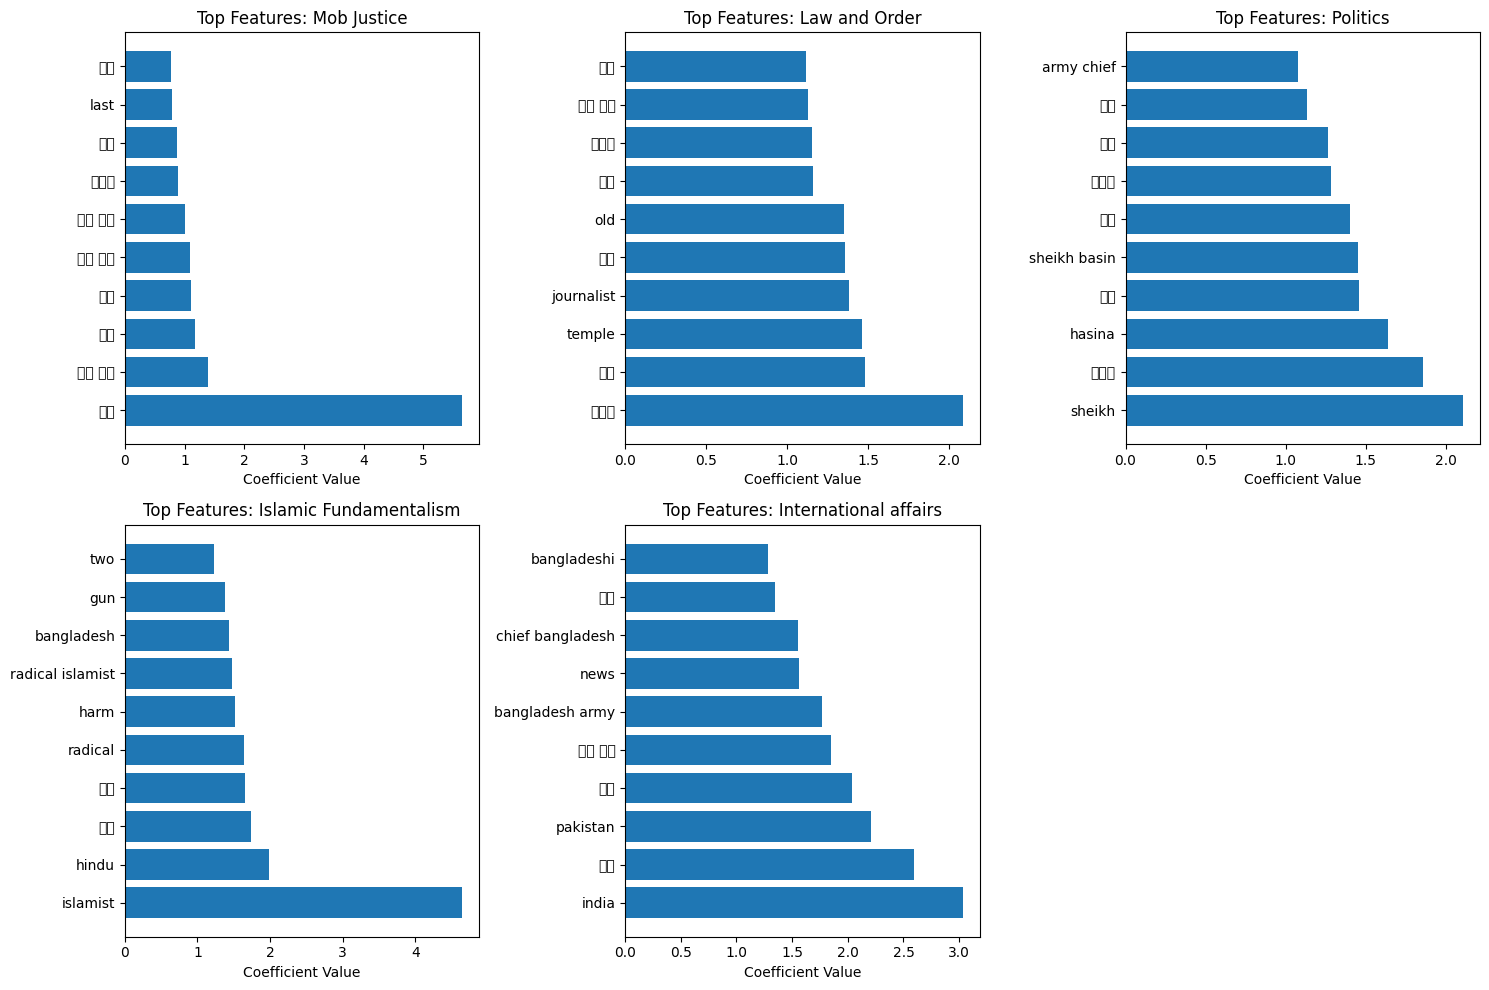


Sample prediction:
Text: 'Police arrested three individuals involved in corruption at the ministry'
Predicted Topic: Law and Order
Top 3 predictions:
  Law and Order: 0.1171
  Religion: 0.0997
  Culture & Lifestyle: 0.0978


In [ ]:
# # Identify the most important features for each class
# print("\nMost important features for each class:")
# feature_names = tfidf_vectorizer.get_feature_names_out()

# # Create a DataFrame to store feature importance for visualization
# feature_importance_data = []

# for i, class_label in enumerate(model.classes_):
#     # Get top features with highest coefficients for this class
#     top_features_idx = np.argsort(model.coef_[i])[-15:]
#     top_features = [feature_names[idx] for idx in top_features_idx]
#     top_coefficients = [model.coef_[i][idx] for idx in top_features_idx]

#     # Add to the feature importance data
#     for feature, coef in zip(top_features, top_coefficients):
#         feature_importance_data.append({
#             'Class': class_label,
#             'Feature': feature,
#             'Importance': coef
#         })

#     # Print top features for this class
#     print(f"Class '{class_label}': {', '.join(top_features)}")

# # Create a bar chart showing performance metrics per class
# print("\nVisualizing per-class performance...")
# class_report = classification_report(y_test, y_test_pred, output_dict=True)
# class_df = pd.DataFrame(class_report).transpose()
# metrics_df = class_df[['precision', 'recall', 'f1-score']].iloc[:-3]  # Remove avg/total rows

# plt.figure(figsize=(12, 8))
# metrics_df.plot(kind='bar', figsize=(12, 8))
# plt.title('Performance Metrics by Class')
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.savefig('class_performance.png')  # Save the figure
# plt.show()

# # Display detailed per-class metrics
# print("\nDetailed per-class metrics (sorted by F1-score):")
# print(class_df[['precision', 'recall', 'f1-score', 'support']].sort_values(by='f1-score'))

# # Display class distribution comparison
# print("\nClass counts comparison (original train vs. resampled train vs. test):")
# original_train_counts = pd.Series(y_train).value_counts().sort_index()
# resampled_train_counts = pd.Series(y_train_resampled).value_counts().sort_index()
# test_counts = pd.Series(y_test).value_counts().sort_index()

# comparison_df = pd.DataFrame({
#     'Original Train': original_train_counts,
#     'Resampled Train': resampled_train_counts,
#     'Test': test_counts
# }).fillna(0).astype(int)

# print(comparison_df)

# # Visualize top features for the most prevalent classes
# top_classes = class_counts.index[:5]  # Top 5 classes
# plt.figure(figsize=(15, 10))
# for i, class_name in enumerate(top_classes):
#     class_data = [item for item in feature_importance_data if item['Class'] == class_name]
#     class_data = sorted(class_data, key=lambda x: x['Importance'], reverse=True)[:10]

#     plt.subplot(2, 3, i+1)
#     features = [item['Feature'] for item in class_data]
#     importances = [item['Importance'] for item in class_data]

#     y_pos = np.arange(len(features))
#     plt.barh(y_pos, importances, align='center')
#     plt.yticks(y_pos, features)
#     plt.xlabel('Coefficient Value')
#     plt.title(f"Top Features: {class_name}")

# plt.tight_layout()
# plt.savefig('top_features.png')  # Save the figure
# plt.show()

# # Function for prediction with new text
# def predict_topic(text):
#     # Preprocess the text
#     clean_text = preprocess_text(text)
#     # Vectorize the text
#     text_tfidf = tfidf_vectorizer.transform([clean_text])
#     # Predict the topic
#     prediction = model.predict(text_tfidf)[0]
#     # Get prediction probabilities
#     proba = model.predict_proba(text_tfidf)[0]
#     # Find top 3 classes
#     top3_idx = proba.argsort()[-3:][::-1]
#     top3_classes = [model.classes_[i] for i in top3_idx]
#     top3_probs = [proba[i] for i in top3_idx]

#     return {
#         'predicted_topic': prediction,
#         'top3_topics': list(zip(top3_classes, top3_probs))
#     }

# # Demo prediction with sample text
# sample_text = "Police arrested three individuals involved in corruption at the ministry"
# prediction_result = predict_topic(sample_text)
# print("\nSample prediction:")
# print(f"Text: '{sample_text}'")
# print(f"Predicted Topic: {prediction_result['predicted_topic']}")
# print("Top 3 predictions:")
# for topic, prob in prediction_result['top3_topics']:
#     print(f"  {topic}: {prob:.4f}")